100%|██████████| 800/800 [00:34<00:00, 23.25it/s] 


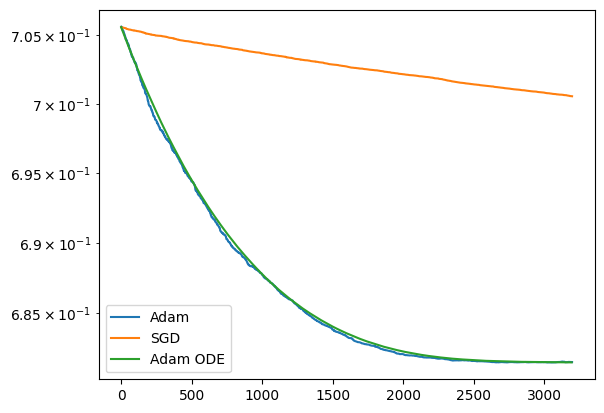

In [1]:
from optimizers import Adam, SGD
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt

# Setup the problem and parameters
problem_type = 'logreg' # from  'logreg' or 'linreg'

d = 400 # dimension
m = 1
beta1 = 0 
beta2 = 0.7
T = 8 # time to run SDE for

lr = 0.4 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

# cov = jnp.linspace(0.1, 1, d) # initialize with diagonal covariance
cov = jnp.array([j**(-0.5) for j in range(1, d+1)])
# cov = jnp.ones(d)
# cov = jnp.diag(cov)

# params0 = jnp.linspace(2,0.1,d)
# optimal_params = jnp.linspace(0.1,2,d)
key = jax.random.PRNGKey(np.random.randint(0, 10000))
key_init, key_opt, key = jax.random.split(key, 3)

params0 = jax.random.normal(key_init, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)


# Run the optimizers
adam = Adam(problem_type)
sgd = SGD(problem_type)

_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)

# Run the SDE equivalents
sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

# _, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
# params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2)

# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
# sgd_ode = SgdODE(problem_type)

# sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(sgd_risks, label = 'SGD')

# plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
# plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

plt.plot(time * d, adam_risk, label = 'Adam ODE')
# plt.plot(time * d, sgd_risk, label = 'SGD ODE')

plt.legend()
plt.show()

In [ ]:
from utils import make_B
params = params0
B = make_B(params0, optimal_params, cov)

var_force = cov
p = jnp.array([jnp.outer(params[j,:], params[j,:]) * cov[j] for j in range(d)])
q = jnp.array([jnp.outer(optimal_params[j,:], optimal_params[j,:]) * cov[j] for j in range(d)])
u = jnp.array([jnp.outer(params[j,:], optimal_params[j,:]) * cov[j] for j in range(d)])

B11 = jnp.sum(p,axis = 0)
B12 = jnp.sum(u,axis = 0)
B22 = jnp.sum(q,axis = 0)

B = jnp.block([[B11,B12],[B12.T,B22]])

In [3]:
## Mock update the ODEs
from risks_and_discounts import phi_from_B, cov_from_B, f_linreg
subkey_mean, subkey_cov, key = jax.random.split(key, 3)

phi = phi_from_B(B, f_linreg, beta2, subkey_mean)
sigma = cov_from_B(B, f_linreg, beta2, subkey_cov)
eigs = jnp.sqrt(cov)
phi1, phi2 = phi[0:m], phi[m:]

In [4]:
p_update = -lr * eigs[:,None,None]  * (p * phi1 + 2 * u * phi2) + lr**2 * var_force[:,None,None] * sigma / d
u_update = -lr * eigs[:,None,None] * (phi1 * u + phi2 * q)
                            
                            
upd = jnp.concatenate([p_update, u_update, jnp.zeros(u_update.shape)])


In [5]:
upd.shape

(900, 3, 3)

In [6]:
p, u, q = upd[:d,:,:], upd[d:2*d,:,:], upd[2*d:,:,:]

In [7]:
p.shape

(300, 3, 3)

In [8]:
## Mock update the ODEs
from risks_and_discounts import phi_from_B, cov_from_B, f_linreg
subkey_mean, subkey_cov, key = jax.random.split(key, 3)

phi1_B, phi2_B = phi_from_B(B, f_linreg, beta2, subkey_mean)
eigs = jnp.sqrt(cov)

p_update = -lr * eigs * (2 * p * phi1_B + phi2_B * (u + v))
p_update += lr**2 * cov_from_B(B, f_linreg, beta2, subkey_cov) * var_force / d

u_update = -lr * eigs * (phi1_B * u + phi2_B * q)
v_update = -lr * eigs * (phi1_B * v + phi2_B * q)

ValueError: too many values to unpack (expected 2)

In [ ]:
B11 = jnp.sum(p,axis = 0)
B12 = jnp.sum(u,axis = 0)
B22 = jnp.sum(q,axis = 0)

jnp.block([[B11,B12],[B12.T,B22]])

[[ 0.78738     0.00427     0.02257     0.0682      0.00845    -0.07149   ]
 [ 0.00427     0.82299995 -0.07172     0.02967     0.06704    -0.02006   ]
 [ 0.02257    -0.07172     0.78507    -0.03008     0.03699    -0.01781   ]
 [ 0.0682      0.02967    -0.03008     0.79855996 -0.0341      0.06784   ]
 [ 0.00845     0.06704     0.03699    -0.0341      0.81714     0.08738   ]
 [-0.07149    -0.02006    -0.01781     0.06784     0.08738     0.77374   ]]


In [ ]:
print(jnp.round(B,5))

[[ 0.78738     0.00427     0.02257     0.0682      0.00845    -0.07149   ]
 [ 0.00427     0.82299995 -0.07172     0.02967     0.06704    -0.02006   ]
 [ 0.02257    -0.07172     0.78507    -0.03008     0.03699    -0.01781   ]
 [ 0.0682      0.02967    -0.03008     0.79855996 -0.0341      0.06784   ]
 [ 0.00845     0.06704     0.03699    -0.0341      0.81714     0.08738   ]
 [-0.07149    -0.02006    -0.01781     0.06784     0.08738     0.77374   ]]


In [ ]:
cov

Array([0.1       , 0.10468227, 0.10936455, 0.11404683, 0.1187291 ,
       0.12341137, 0.12809364, 0.13277592, 0.13745819, 0.14214046,
       0.14682274, 0.15150501, 0.1561873 , 0.16086957, 0.16555184,
       0.17023411, 0.17491639, 0.17959866, 0.18428093, 0.1889632 ,
       0.19364548, 0.19832775, 0.20301002, 0.2076923 , 0.21237458,
       0.21705684, 0.22173914, 0.2264214 , 0.23110369, 0.23578593,
       0.24046823, 0.24515049, 0.24983278, 0.25451505, 0.25919732,
       0.2638796 , 0.26856187, 0.27324414, 0.27792642, 0.2826087 ,
       0.28729096, 0.29197323, 0.2966555 , 0.30133778, 0.30602005,
       0.31070232, 0.3153846 , 0.32006687, 0.32474917, 0.3294314 ,
       0.33411372, 0.338796  , 0.34347826, 0.34816054, 0.3528428 ,
       0.35752508, 0.36220735, 0.36688963, 0.3715719 , 0.3762542 ,
       0.38093644, 0.38561872, 0.390301  , 0.3949833 , 0.39966553,
       0.4043478 , 0.4090301 , 0.41371238, 0.41839463, 0.4230769 ,
       0.4277592 , 0.43244147, 0.43712375, 0.441806  , 0.44648